In [1]:
# import packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
seed = 2724

### Import data

In [3]:
DF_PATH = "mod04_data/sample.csv"
df = pd.read_csv(DF_PATH)

### Separate data by independent (X) and dependent (y) variables

In [4]:
X = df[["income", "education_years", "zipcode_score"]]
y = df["target"]

### Split the data into a _training_ set (to build a model) and _test_ set (to validate a model)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed
)

### Build a model on the training set

In [6]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=seed
)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=2724)

### Use SHAP to explain the model on test data

In [7]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

100%|===================| 1499/1500 [02:05<00:00]        

This will allow us to see which variables are most important to predicting the outcome.

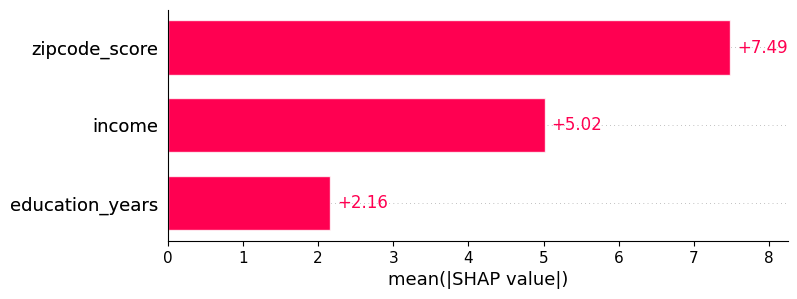

In [8]:
shap.plots.bar(shap_values)

### Import the `group` variable, which was **not** used in training this model.

In [9]:
X_test_with_group = X_test.copy()
X_test_with_group["group"] = df.loc[X_test.index, "group"]

### Look at the difference in SHAP values between the two groups across the variables used in the model.

In [10]:
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_df["group"] = X_test_with_group["group"].values

shap_df.groupby("group").mean()

,income,education_years,zipcode_score
group,,,
0,1.086254,-0.170779,5.866534
1,1.020094,-0.192841,-6.859435


### Let's put `group` and `zipcode_score` in the same plot

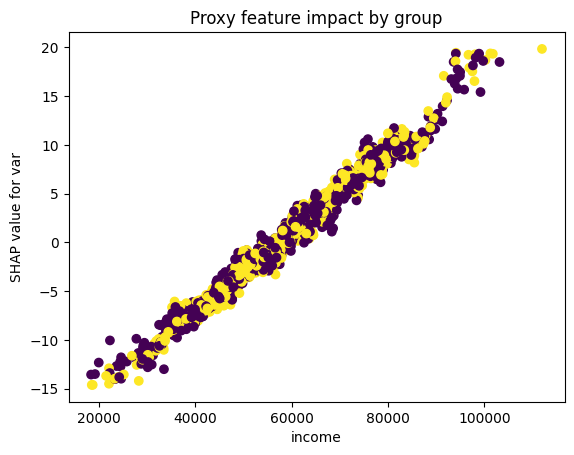

In [12]:
def plot_shap(var):
    # Extract SHAP values for the feature
    shap_var = shap_values[:, var].values

    # Plot the values of each group using different colors
    plt.figure()
    plt.scatter(
        X_test[var],
        shap_var,
        c=X_test_with_group["group"]
    )
    plt.xlabel(var)
    plt.ylabel(f"SHAP value for var")
    plt.title("Proxy feature impact by group")
    plt.show()

plot_shap("income")

# Discussion Questions

### What is a _SHAP_ (or Shapley) value? 

A Shapley value is a way of discerning which variables will contribute the most to the outcome of a model. 

### Suppose you built this model and then it is peer reviewed by another entity. If the reviewer asks whether you used the variable `group` in your model, what would your answer be?

My answer would be no, as it is clear that when including the variable group in the model, we get some distinct correlation between a zipcode score and each group.

### If the reviewer asks whether the outcome of your model is correlated with `group`, what would your answer be?

Yes, the outcome of the model is in fact correlated with group as the group largely correlates with what zip score each sample point has.

### Construct a "proxy feature impact by group" plot for `income`. How is this plot different from the one for `zipcode_score`?

Whereas zipcode score has a similar distribution of SHAP values across groups, income has a very different distribution of SHAP values across groups. This suggests that the model is relying on income differently for the two groups, which could indicate bias in the model's predictions.

Type your answer here.

### If, instead, you were the **reviewer**, what other questions might you ask the person who built this model? Give at least two.

I would ask the person who built the model if income and education years have correlation, and if so how strongly. I would also probably ask why the zipcode score is so distinct for each group, and what each group entails for differences between the two. There could be more specific variables in group 1 that cause a significantly lower outcome score that could be modeled.